## Data Scrapper for ATP Ranking

- Get the data from the ATP Website: https://www.atptour.com/en/rankings/singles?rankRange=1-5000&rank
- Data Cleaning: 
    - Transform the data types 
    - Transform nAn values
- Questions to solve: 
    - Look what are the top 100 players
    - Where are living the best players in the world?

In [1]:
#Beautiful Soup
from bs4 import BeautifulSoup
import bs4
import requests
# Selenium
from selenium.webdriver.common.by import By
from selenium import webdriver

#Pandas and other things
import pandas as pd
import numpy as np

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt


#Ignore warinings
import warnings
# Suppress DeprecationWarnings
warnings.filterwarnings("ignore")

In [2]:
# Set up the Selenium webdriver

DRIVER_PATH = '/path/to/chromedriver'
driver = webdriver.Chrome(executable_path=DRIVER_PATH)
#driver = webdriver.Chrome()
url = 'https://www.atptour.com/en/rankings/singles?rankRange=1-5000&rank'
#https://www.atptour.com/en/rankings/singles?rankRange=1-5000&rankDate=2023-04-03
driver.get(url)

# Parse the HTML with BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

# Create an empty DataFrame to store the player information
players_df = pd.DataFrame(columns=['Rank', 'Name', 'Age', 'Country', 'Points', 'Tournaments'])

Incompatible release of chromedriver (version 98.0.4758.102) detected in PATH: /usr/local/bin/chromedriver


In [3]:
# Find the table containing the player rankings
table = soup.find('table', {'class': 'mega-table'})

# Check if the table exists
if table:
    # Loop through each player row and extract their information
    for row in table.find_all('tr')[1:]:
        # Extract the player's rank
        rank = row.find('td', {'class': 'rank-cell'}).text.strip()

        # Extract the player's name
        name = row.find('td', {'class': 'player-cell'}).text.strip()

        # Extract the player's age
        age = row.find('td', {'class': 'age-cell'}).text.strip()

        # Extract the player's country
        country = row.find('img').get('alt')

        # Extract the player's points
        points = row.find('td', {'class': 'points-cell'}).text.strip()

        # Extract the number of tournaments played by the player
        tournaments = row.find('td', {'class': 'tourn-cell'}).text.strip()

        # Print the extracted information
        #print(f"Rank: {rank}\nName: {name}\nAge: {age}\nCountry: {country}\nPoints: {points}\nTournaments: {tournaments}\n")
        players_df = players_df.append({'Rank': rank, 'Name': name, 'Age': age, 'Country': country, 'Points': points, 'Tournaments': tournaments}, ignore_index=True)
else:
    print(f"No table found in the HTML content of {url}")

driver.quit()
    

### Is everything working so far??
So up to know we gathered the Data from the ATP Website (which is pretty cool). 
We could also do that for different timestamps by just adjust the the URL a little bit 
 - https://www.atptour.com/en/rankings/singles?rankRange=1-5000&rankDate=2023-04-03 
You can see immediatly that the timestamp is on a specific date.


But now let's have a first look into our gathered data.

In [5]:
players_df[1050:1300]

,Rank,Name,Age,Country,Points,Tournaments
1050,1051T,Yuttana Charoenphon,22,THA,10,14
1051,1051T,Alexander Crnokrak,23,AUS,10,14
1052,1053,Federico Campana,25,ITA,10,14
1053,1054,Ishaque Eqbal,25,IND,10,14
1054,1055,Eero Vasa,26,FIN,10,15
...,...,...,...,...,...,...
1295,1296T,Juan Manuel Benitez Chavarriaga,27,COL,4,2
1296,1296T,Damien Salvestre,21,FRA,4,2
1297,1298T,Joel Josef Schwärzler,17,AUT,4,3
1298,1298T,Ryan Seggerman,23,USA,4,3


In [6]:
players_df.tail()

,Rank,Name,Age,Country,Points,Tournaments
2026,2023T,Matt Ponchet,18,FRA,1,9
2027,2023T,Joao Eduardo Schiessl,18,BRA,1,9
2028,2023T,Stefan Vujic,25,AUS,1,9
2029,2030T,Lorenzo Ferri,19,ITA,1,10
2030,2030T,Giammarco Gandolfi,19,ITA,1,10


In [7]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rank         2031 non-null   object
 1   Name         2031 non-null   object
 2   Age          2031 non-null   object
 3   Country      2031 non-null   object
 4   Points       2031 non-null   object
 5   Tournaments  2031 non-null   object
dtypes: object(6)
memory usage: 95.3+ KB


### Something is quite weird....

First of all. The Data is right, which is pretty good for our analysis. But certain aspects of the data are unhandy to deal with. 
1. We see that the points have a ',' as delimeter for the thousands unit 
    - for all sorts of analysis it is crucial that the data is in the right form (e.g. in this representation 1 Novak Djokovic (#1) in the current time, got less points than Ben Shelton (#39) which is simply wrong)
2. The rank of a player is provided with an additional T for the players who are higher ranked than 1052 (tbh. i don't know the reason)
    - for this we just have to cut/replacr the T and the rank is finished
    - please be aware that, nevertheless that we change the number of the ranking does not change
3. The datatypes are completly wild, therefore we have to adjust them
    - as i first got the data i was wondering why the mean of a group of 20-year olds got a value of 23453223.2323 (this was because of the wrong datatype of the columns (therefore it is important to check the datatypes)

#### Change of the datatypes

In [8]:
players_df['Rank'] = players_df['Rank'].str.replace('T', '').astype(int)
players_df['Age'] = players_df['Age'].replace('', np.nan)
# convert column to float
players_df['Age'] = players_df['Age'].astype(float)
players_df['Name'] = players_df['Name'].astype(str)
players_df['Points'] = players_df['Points'].str.replace(',', '').astype(float)
players_df['Tournaments'] = players_df['Tournaments'].astype(int)
players_df['Name'] = players_df['Name'].astype(str)

In [9]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rank         2031 non-null   int64  
 1   Name         2031 non-null   object 
 2   Age          2019 non-null   float64
 3   Country      2031 non-null   object 
 4   Points       2031 non-null   float64
 5   Tournaments  2031 non-null   int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 95.3+ KB


### Let's goooooo
Since our data is kind of clean we can start our analysis with gently easy analysis.
- First i just want to have a summary of my data
- than i would like to know who are the top 100 of the ATP and where are they come from 

In [10]:
players_df.describe()

,Rank,Age,Points,Tournaments
count,2031.000000,2019.000000,2031.000000,2031.000000
mean,1009.327425,23.784547,124.784343,12.984244
std,577.880913,4.445757,424.046734,9.365735
min,1.000000,15.000000,1.000000,1.000000
25%,508.500000,21.000000,2.000000,5.000000
50%,1016.000000,23.000000,11.000000,11.000000
75%,1520.000000,26.000000,72.000000,21.000000
max,2030.000000,45.000000,6815.000000,41.000000


### This is quite interesting....
As we can see the average player on the ATP tour is around 24 years old, which in my perspective is pretty young of a player. I was aspecting that the average player is 3 to 5 years older. 

Next have a look on where these players come from. How we do that?? Yes with a good vizualization ;)

In [11]:
#since we have 96 countries let's say that every country which has less than 4 players in 
#the ranking we summarize them into the 'other' section
players_df.groupby(['Country']).size().sort_values(ascending=True)

Country
MAS      1
NMI      1
GUD      1
PAK      1
CAM      1
      ... 
ESP     88
GER     89
FRA    148
ITA    164
USA    198
Length: 97, dtype: int64

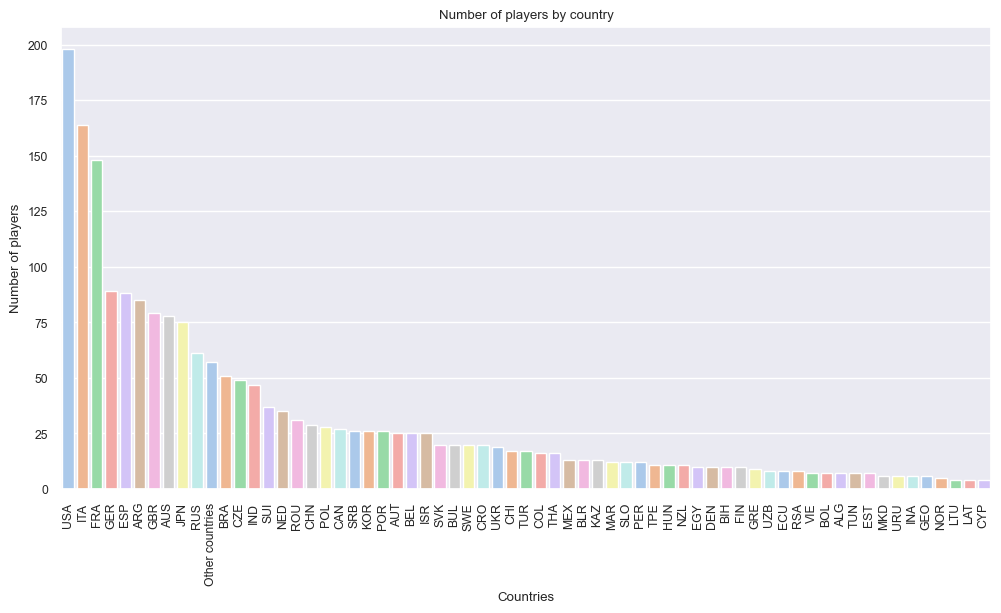

In [12]:
df = players_df.copy()
# Set font size
sns.set(font_scale=0.8)

# Set figure size
plt.figure(figsize=(12,6))

# Group countries with less than 4 players into a new category
country_counts = df['Country'].value_counts()
df['Country'] = df['Country'].apply(lambda x: x if country_counts[x] >= 4 else 'Other countries')

# Sort countries in descending order
order = df['Country'].value_counts().index.sort_values(ascending=False)

# Create a countplot of the 'Country' column
sns.countplot(x='Country', data=df, palette='pastel', order=df['Country'].value_counts().index)
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add title and labels
plt.title('Number of players by country')
plt.xlabel('Countries')
plt.ylabel('Number of players')

# Show the plot
plt.show()

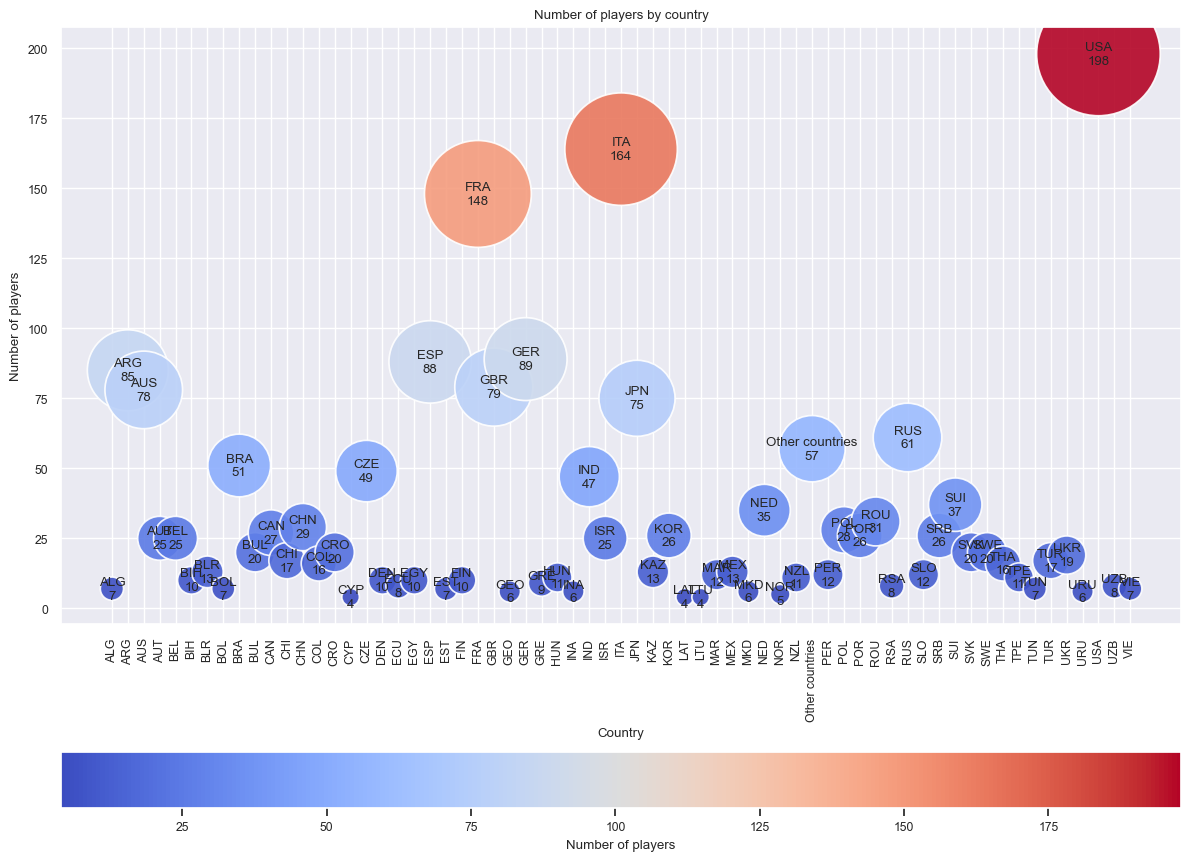

In [13]:
# Create a copy of the original dataframe to avoid modifying the original data
df = players_df.copy()

# Group countries with less than 4 players into a new category
country_counts = df['Country'].value_counts()
df['Country'] = df['Country'].apply(lambda x: x if country_counts[x] >= 4 else 'Other countries')

# Aggregate the number of players by country
agg = df.groupby('Country', as_index=False)['Name'].agg('count')

# Set the size of the bubbles based on the number of players
sizes = agg['Name'] * 40

# Determine the color range based on the number of players
num_players = agg['Name'].to_numpy()
min_players = np.min(num_players)
max_players = np.max(num_players)
norm = plt.Normalize(min_players, max_players)

# Create the bubble chart
plt.figure(figsize=(12,9))
scatter = sns.scatterplot(x='Country', y='Name', data=agg, s=sizes, alpha=0.9, hue=num_players, palette='coolwarm', legend=False)
plt.xticks(rotation=90)

# Add title and labels
plt.title('Number of players by country')
plt.xlabel('Country')
plt.ylabel('Number of players')

# Add the number of players and the country name inside each bubble
for index, row in agg.iterrows():
    plt.text(row['Country'], row['Name'], row['Country'] + '\n' + str(row['Name']), ha='center', va='center')

# Add a color bar legend
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Number of players', orientation='horizontal', pad=0.15)

# Show the plot
plt.tight_layout()
plt.show()


### Good to know:
As we can see the country with the highest amount of players inside the ATP Ranking is 
1. USA 
2. Italy
3. France
4. Spain 
5. Germany

But how about the players point of theses players??

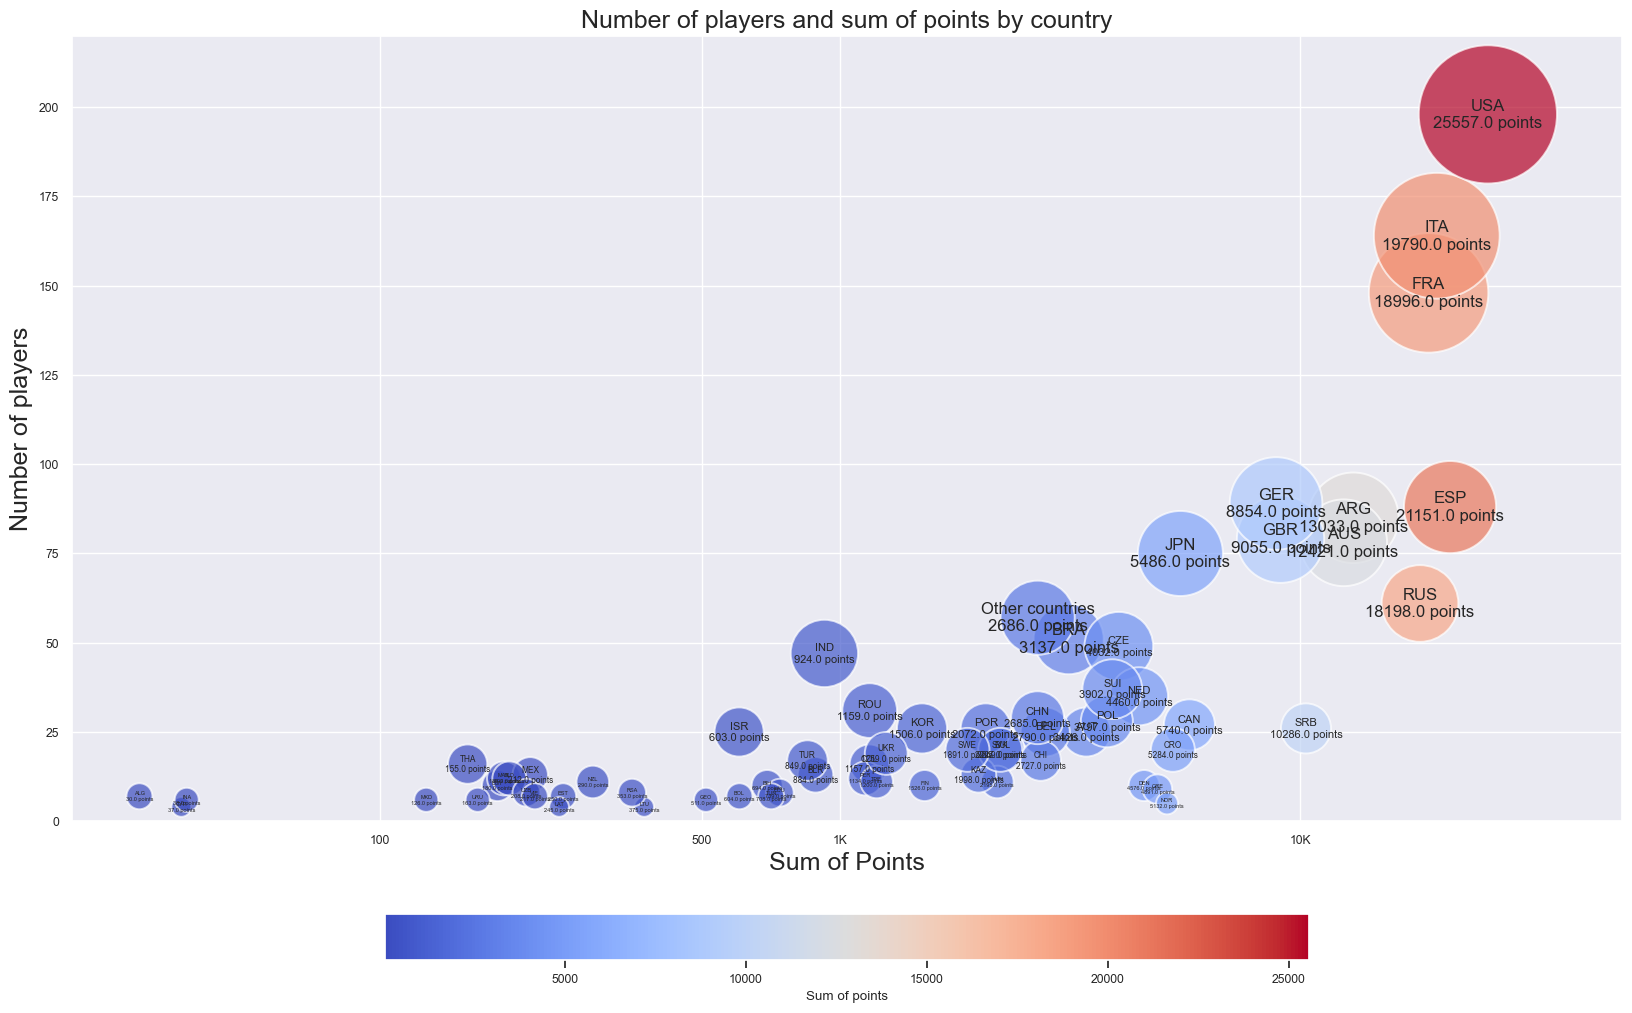

In [14]:
def get_font_size(size):
    """
    Returns the font size based on the size of the bubble
    """
    if size < 100:
        return 2
    elif size < 500:
        return 4
    elif size < 1000:
        return 6
    elif size < 2000:
        return 8
    else:
        return 12

# Create a copy of the original dataframe to avoid modifying the original data
df = players_df.copy()

# Group countries with less than 4 players into a new category
country_counts = df['Country'].value_counts()
df['Country'] = df['Country'].apply(lambda x: x if country_counts[x] >= 4 else 'Other countries')

# Aggregate the number of players by country and sum the points for each country
agg = df.groupby('Country', as_index=False).agg({'Name': 'count', 'Points': 'sum'})
agg = agg.rename(columns={'Name': 'Num Players'})

# Set the size of the bubbles based on the number of players
sizes = agg['Num Players'] * 50

# Determine the color range based on the sum of points
sum_points = agg['Points'].to_numpy()
min_points = np.min(sum_points)
max_points = np.max(sum_points)
norm = plt.Normalize(min_points, max_points)

# Create the bubble chart
plt.figure(figsize=(20,12))
scatter = sns.scatterplot(x='Points', y='Num Players', data=agg, s=sizes, alpha=0.7, hue=sum_points, palette='coolwarm', legend=False)
plt.xscale('log')
plt.xticks([ 100, 500, 1000, 10000], [ '100', '500', '1K', '10K'])
plt.xlabel('Sum of Points', fontsize=18)
plt.ylabel('Number of players', fontsize=18)
plt.ylim(0, 220)
plt.xlim(0, 50000)

# Add title and labels
plt.title('Number of players and sum of points by country', fontsize=18)

# Add the number of players, sum of points and the country name inside each bubble
for index, row in agg.iterrows():
    font_size = get_font_size(row['Num Players']*40)
    plt.text(row['Points'], row['Num Players'], row['Country'] + '\n' + str(row['Points']) + ' points' , ha='center', va='center', fontsize=font_size)
    #plt.text(row['Points'], row['Num Players'], row['Country'] + '\n' + str(row['Num Players']) + ' players\n' + str(row['Points']) + ' points', ha='center', va='center', fontsize=font_size)

# Add a color bar legend
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Sum of points', orientation='horizontal', fraction=0.05, pad=0.1)


# Show the plot
plt.show()


### Okay nice
That is really very interesting. Just because it says that a country has a lot of players in the ATP rankings doesn't necessarily mean that they are well represented in the world rankings. The indicator that a player has a high position in the ranking is that he has a lot of ATP points. 

In this case, Germany, for example, is no longer ranked 5th and is further down. Spain, on the other hand, is in second place and thus 'overtakes' France and Italy.

Maybe Just have a closer look in just the numbers.

In [15]:
players_df.head()

,Rank,Name,Age,Country,Points,Tournaments
0,1,Carlos Alcaraz,20.0,ESP,6815.0,17
1,2,Daniil Medvedev,27.0,RUS,6330.0,23
2,3,Novak Djokovic,36.0,SRB,5955.0,16
3,4,Casper Ruud,24.0,NOR,4960.0,24
4,5,Stefanos Tsitsipas,24.0,GRE,4775.0,21


In [16]:
players_df.groupby(['Country'])['Points'].sum().sort_values(ascending=True)

Country
GUD        1.0
MLT        1.0
SRI        1.0
KUW        2.0
PHI        2.0
        ...   
RUS    18198.0
FRA    18996.0
ITA    19790.0
ESP    21151.0
USA    25557.0
Name: Points, Length: 97, dtype: float64

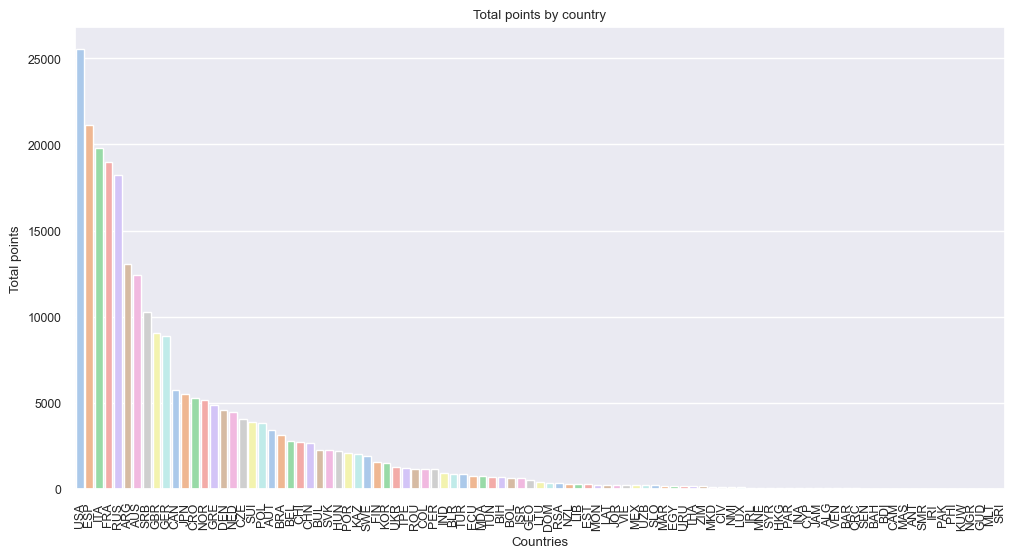

In [17]:
# Set font size
sns.set(font_scale=0.8)

# Set figure size
plt.figure(figsize=(12,6))

# Group points by country and sum them up
points_by_country = players_df.groupby('Country')['Points'].sum().reset_index()

# Sort countries by total points in descending order
points_by_country = points_by_country.sort_values('Points', ascending=False)

# Create a bar plot of the 'Points' column
sns.barplot(x='Country', y='Points', data=points_by_country, palette='pastel', order=points_by_country['Country'])
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
#plt.text(row.name, row.Points, row.Points, color='black', ha="center")

# Add title and labels
plt.title('Total points by country')
plt.xlabel('Countries')
plt.ylabel('Total points')

# Show the plot
plt.show()


### As we can see...
Spain is now on second place but germany has fallen far behind. 

So, as we had already suspected, having many players in the world rankings does not necessarily mean much. The players with the highest ranking do not necessarily come from the countries with the most players in the ranking. 

### But which country has the best utilisation of points in relation to the number of players?

*** 
### Looking for top 100

In [18]:
top_100 = players_df[0:100]

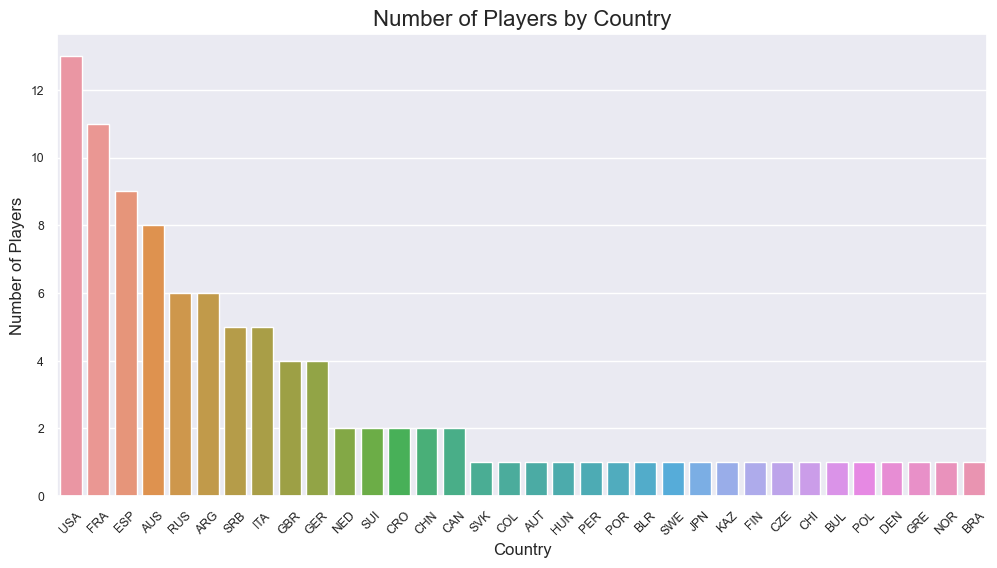

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set font size
sns.set(font_scale=0.8)

# Set figure size
plt.figure(figsize=(12,6))

# Plot countplot
ax = sns.countplot(x='Country', data=top_100, order=top_100['Country'].value_counts().index)

# Set title and labels
ax.set_title('Number of Players by Country', fontsize=16)
ax.set_xlabel('Country', fontsize=12)
ax.set_ylabel('Number of Players', fontsize=12)

# Adjust x-axis labels rotation
plt.xticks(rotation=45)

# Show plot
plt.show()


In [20]:
top_100.tail()

,Rank,Name,Age,Country,Points,Tournaments
95,96,Federico Coria,31.0,ARG,656.0,30
96,97,Aleksandar Vukic,27.0,AUS,654.0,27
97,98,Thiago Monteiro,28.0,BRA,652.0,29
98,99,Roman Safiullin,25.0,RUS,647.0,18
99,100,Jenson Brooksby,22.0,USA,640.0,21


In [21]:
top_100.groupby(['Country']).size().sort_values(ascending=False)

Country
USA    13
FRA    11
ESP     9
AUS     8
RUS     6
ARG     6
ITA     5
SRB     5
GBR     4
GER     4
CRO     2
NED     2
SUI     2
CHN     2
CAN     2
BRA     1
PER     1
SWE     1
SVK     1
DEN     1
BUL     1
AUT     1
POR     1
POL     1
NOR     1
COL     1
FIN     1
CZE     1
JPN     1
CHI     1
HUN     1
GRE     1
BLR     1
KAZ     1
dtype: int64

In [22]:
top_100_bel = top_100[top_100['Country'] == 'BEL']
top_100_bel

,Rank,Name,Age,Country,Points,Tournaments


In [23]:
top_100_ger = top_100[top_100['Country'] == 'GER']
top_100_ger

,Rank,Name,Age,Country,Points,Tournaments
26,27,Alexander Zverev,26.0,GER,1450.0,20
27,28,Jan-Lennard Struff,33.0,GER,1447.0,25
64,65,Yannick Hanfmann,31.0,GER,791.0,24
78,79,Daniel Altmaier,24.0,GER,733.0,28


In [24]:
top_100_fra = top_100[top_100['Country'] == 'FRA']
top_100_fra

,Rank,Name,Age,Country,Points,Tournaments
39,40,Ugo Humbert,24.0,FRA,1026.0,28
46,47,Adrian Mannarino,34.0,FRA,937.0,31
51,52,Richard Gasquet,36.0,FRA,901.0,28
57,58,Gregoire Barrere,29.0,FRA,850.0,30
60,61,Corentin Moutet,24.0,FRA,823.0,20
62,63,Arthur Fils,18.0,FRA,807.0,26
65,66,Benjamin Bonzi,26.0,FRA,783.0,26
69,70,Constant Lestienne,31.0,FRA,769.0,28
77,78,Arthur Rinderknech,27.0,FRA,735.0,24
81,82,Luca Van Assche,19.0,FRA,725.0,32


In [25]:
top_100_esp = top_100[top_100['Country'] == 'ESP']
top_100_esp

,Rank,Name,Age,Country,Points,Tournaments
0,1,Carlos Alcaraz,20.0,ESP,6815.0,17
14,15,Rafael Nadal,36.0,ESP,2445.0,14
20,21,Pablo Carreno Busta,31.0,ESP,1740.0,20
23,24,Roberto Bautista Agut,35.0,ESP,1485.0,27
33,34,Alejandro Davidovich Fokina,23.0,ESP,1115.0,25
37,38,Bernabe Zapata Miralles,26.0,ESP,1051.0,27
56,57,Roberto Carballes Baena,30.0,ESP,850.0,30
66,67,Albert Ramos-Vinolas,35.0,ESP,782.0,32
80,81,Jaume Munar,26.0,ESP,725.0,30


In [26]:
top_100_ita = top_100[top_100['Country'] == 'ITA']
mean_age_ita = top_100_ita['Age'].mean()
print(mean_age_ita)

25.4


In [27]:
np.mean(top_100[top_100['Country'] == 'ITA']['Age'])

25.4

*** 

## BACK-UP

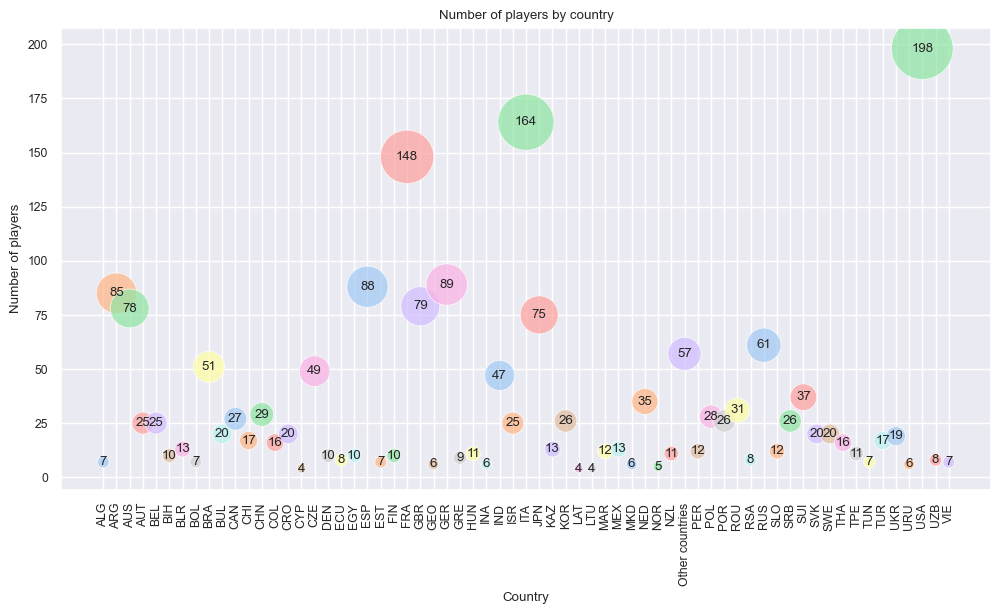

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a copy of the original dataframe to avoid modifying the original data
df = players_df.copy()

# Group countries with less than 4 players into a new category
country_counts = df['Country'].value_counts()
df['Country'] = df['Country'].apply(lambda x: x if country_counts[x] >= 4 else 'Other countries')

# Aggregate the number of players by country
agg = df.groupby('Country', as_index=False)['Name'].agg('count')

# Set the size of the bubbles based on the number of players
sizes = agg['Name'] * 10

# Create the bubble chart
plt.figure(figsize=(12,6))
sns.scatterplot(x='Country', y='Name', data=agg, s=sizes, alpha=0.7, hue='Country', palette='pastel')
plt.xticks(rotation=90)
# Remove the legend
plt.legend().remove()


# Add title and labels
plt.title('Number of players by country')
plt.xlabel('Country')
plt.ylabel('Number of players')

# Add the number of players and the country name inside each bubble
for index, row in agg.iterrows():
    plt.text(row['Country'], row['Name'], str(row['Name']), ha='center', va='center')

# Show the plot
plt.show()


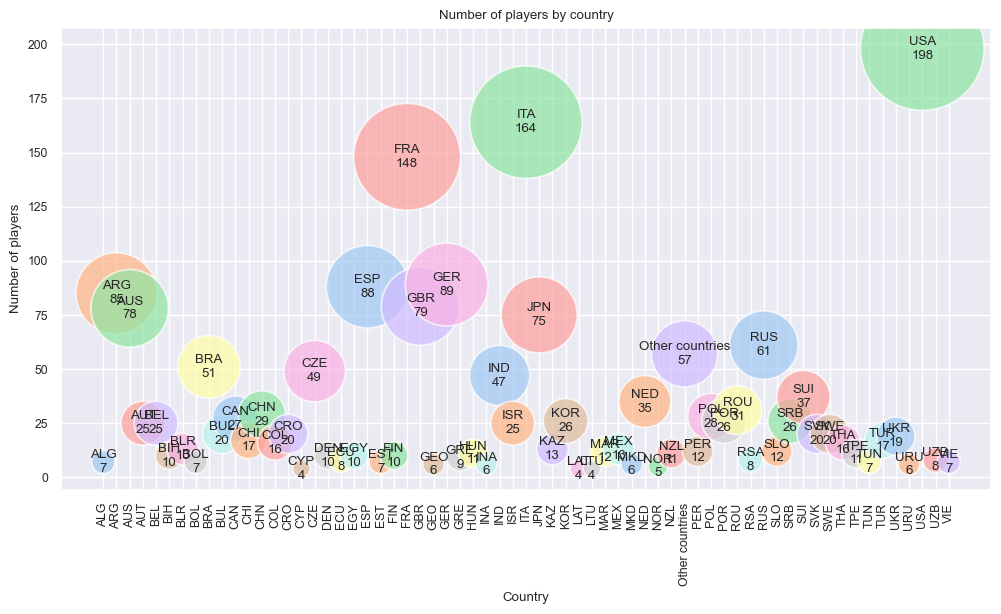

In [29]:

# Create a copy of the original dataframe to avoid modifying the original data
df = players_df.copy()

# Group countries with less than 4 players into a new category
country_counts = df['Country'].value_counts()
df['Country'] = df['Country'].apply(lambda x: x if country_counts[x] >= 4 else 'Other countries')

# Aggregate the number of players by country
agg = df.groupby('Country', as_index=False)['Name'].agg('count')

# Set the size of the bubbles based on the number of players
sizes = agg['Name'] * 40

# Create the bubble chart
plt.figure(figsize=(12,6))
sns.scatterplot(x='Country', y='Name', data=agg, s=sizes, alpha=0.7, hue='Country', palette='pastel')
plt.xticks(rotation=90)
# Remove the legend
plt.legend().remove()

# Add title and labels
plt.title('Number of players by country')
plt.xlabel('Country')
plt.ylabel('Number of players')

# Add the number of players and the country name inside each bubble
for index, row in agg.iterrows():
    plt.text(row['Country'], row['Name'], row['Country'] + '\n' + str(row['Name']), ha='center', va='center')

# Show the plot
plt.show()


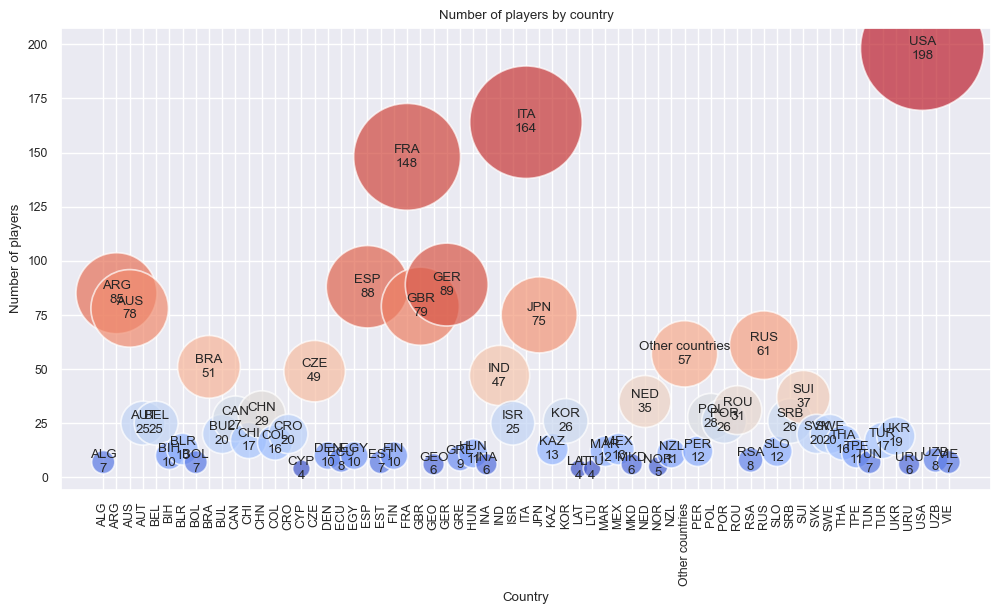

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a copy of the original dataframe to avoid modifying the original data
df = players_df.copy()

# Group countries with less than 4 players into a new category
country_counts = df['Country'].value_counts()
df['Country'] = df['Country'].apply(lambda x: x if country_counts[x] >= 4 else 'Other countries')

# Aggregate the number of players by country
agg = df.groupby('Country', as_index=False)['Name'].agg('count')

# Set the size of the bubbles based on the number of players
sizes = agg['Name'] * 40

# Create a custom palette with a range of colors
num_colors = len(agg['Name'].unique())
custom_palette = sns.color_palette('coolwarm', num_colors)

# Create the bubble chart with the custom palette
plt.figure(figsize=(12,6))
sns.scatterplot(x='Country', y='Name', data=agg, s=sizes, alpha=0.7, hue='Name', palette=custom_palette)
plt.xticks(rotation=90)
# Remove the legend
plt.legend().remove()

# Add title and labels
plt.title('Number of players by country')
plt.xlabel('Country')
plt.ylabel('Number of players')

# Add the number of players and the country name inside each bubble
for index, row in agg.iterrows():
    plt.text(row['Country'], row['Name'], row['Country'] + '\n' + str(row['Name']), ha='center', va='center')

# Show the plot
plt.show()


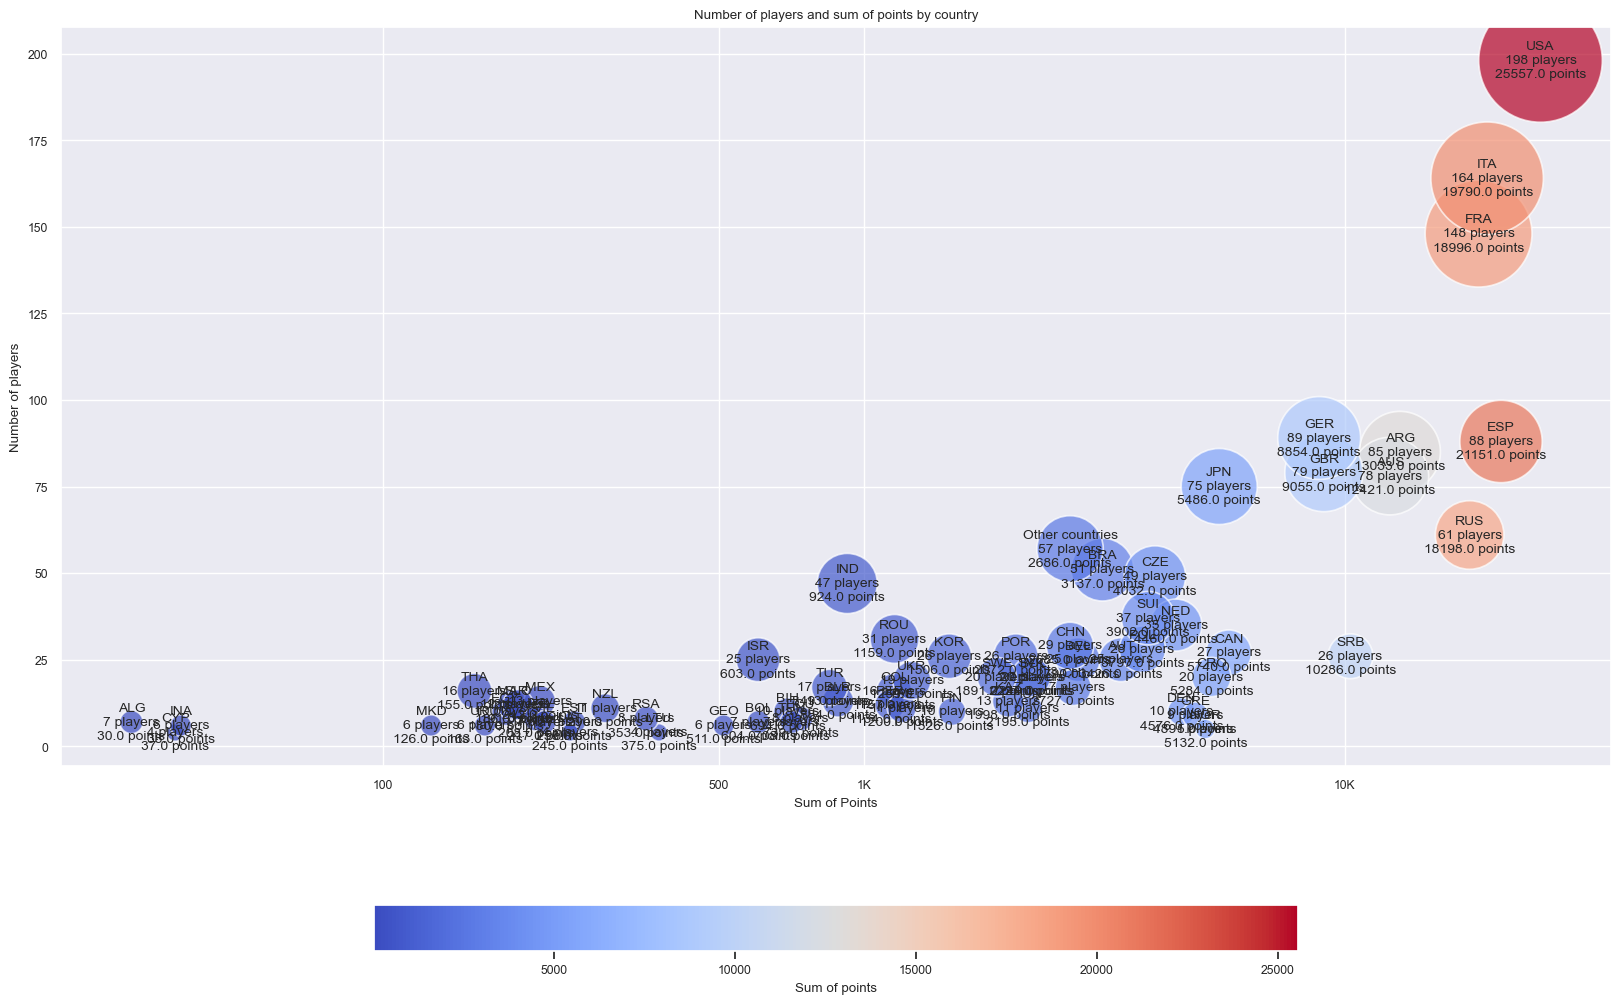

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a copy of the original dataframe to avoid modifying the original data
df = players_df.copy()

# Group countries with less than 4 players into a new category
country_counts = df['Country'].value_counts()
df['Country'] = df['Country'].apply(lambda x: x if country_counts[x] >= 4 else 'Other countries')

# Aggregate the number of players by country and sum the points for each country
agg = df.groupby('Country', as_index=False).agg({'Name': 'count', 'Points': 'sum'})
agg = agg.rename(columns={'Name': 'Num Players'})

# Set the size of the bubbles based on the number of players
sizes = agg['Num Players'] * 40

# Determine the color range based on the sum of points
sum_points = agg['Points'].to_numpy()
min_points = np.min(sum_points)
max_points = np.max(sum_points)
norm = plt.Normalize(min_points, max_points)

# Create the bubble chart
plt.figure(figsize=(20,12))
scatter = sns.scatterplot(x='Points', y='Num Players', data=agg, s=sizes, alpha=0.7, hue=sum_points, palette='coolwarm', legend=False)
plt.xscale('log')
plt.xticks([ 100, 500, 1000, 10000], [ '100', '500', '1K', '10K'])
plt.xlabel('Sum of Points')
plt.ylabel('Number of players')

# Add title and labels
plt.title('Number of players and sum of points by country')

# Add the number of players, sum of points and the country name inside each bubble
for index, row in agg.iterrows():
    plt.text(row['Points'], row['Num Players'], row['Country'] + '\n' + str(row['Num Players']) + ' players\n' + str(row['Points']) + ' points', ha='center', va='center', fontsize=10)

# Add a color bar legend
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Sum of points', orientation='horizontal', fraction=0.05)


# Show the plot
plt.show()


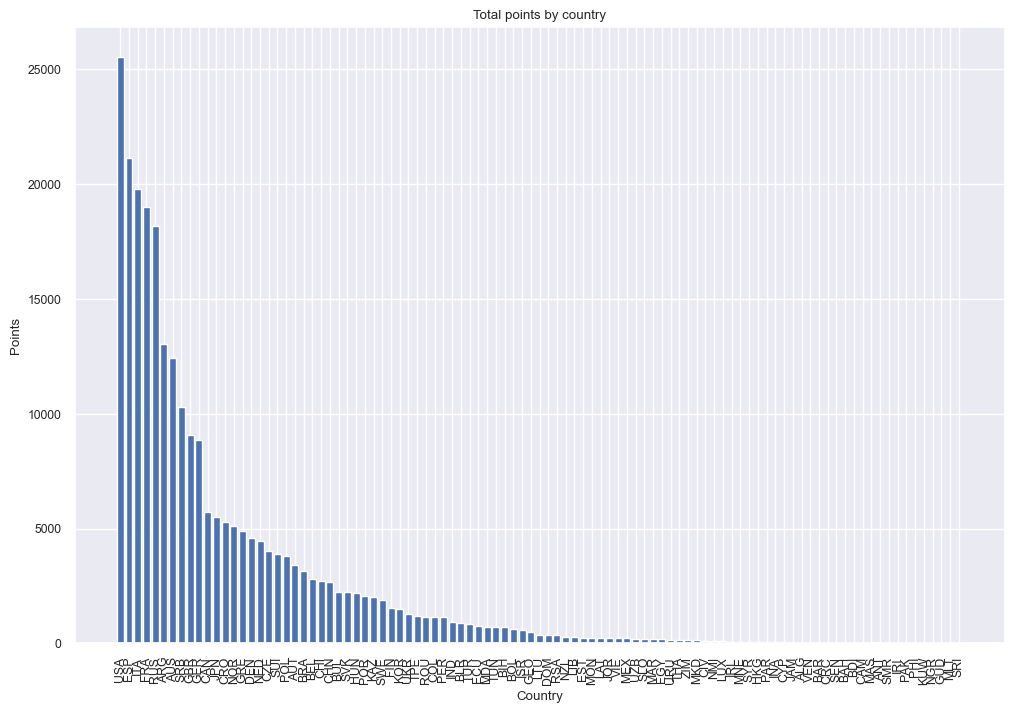

In [32]:
# Group by country and sum the points
country_points = players_df.groupby('Country')['Points'].sum()

# Sort by points in descending order
country_points = country_points.sort_values(ascending=False)

# Create a bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(country_points.index, country_points.values)

# Set labels and title
ax.set_xlabel('Country')
ax.set_ylabel('Points')
ax.set_title('Total points by country')
plt.xticks(rotation=90)
plt.show()
